In [21]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
from astroML.datasets import fetch_sdss_specgals
from astroML.datasets import fetch_sdss_spectrum
from sklearn.ensemble import RandomForestRegressor

## inspiration from the code provided by W. Trick & M. Walther figure 9.15 

In [8]:
## Get SDSS Spectra 
data = fetch_sdss_specgals()
print(data.dtype.names)

('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


661598

In [14]:
import matplotlib.pyplot as plt
from astroML.datasets import fetch_sdss_specgals

# Download the SDSS spectroscopic galaxy data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

In [25]:
### IDEAS TO TEST ### 
# change how many samples you use in the training verse testing data  

In [15]:
# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

In [16]:
# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]

In [18]:
def compute_photoz_forest(depth,nest):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None
    
    z_fit_arr=[]
    
    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=nest,
                                    max_depth=d, random_state=0,n_jobs=-1)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.sqrt(np.mean((z_fit_train - z_train) ** 2))
        rms_test[i] = np.sqrt(np.mean((z_fit - z_test) ** 2))
        score=clf.score(mag_test,z_test)
        z_fit_arr.append(z_fit)
        
        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit
                   
    return rms_test, rms_train, i_best, z_fit_best, z_fit_arr, score

In [19]:
def compute_photoz_forest_nest(depth,nest):
    rms_test = np.zeros(len(nest))
    rms_train = np.zeros(len(nest))
    i_best = 0
    z_fit_best = None
    
    z_fit_arr=[]
    
    for i, n in enumerate(nest):
        clf = RandomForestRegressor(n_estimators=n,
                                    max_depth=depth, random_state=0,n_jobs=-1)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.sqrt(np.mean((z_fit_train - z_train) ** 2))
        rms_test[i] = np.sqrt(np.mean((z_fit - z_test) ** 2))
        
        z_fit_arr.append(z_fit)
        
        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit
                   
    return rms_test, rms_train, i_best, z_fit_best, z_fit_arr, score

In [ ]:
### IDEAS TO TEST ### 
# change the depth of the tree 
# change the number of trees you want in forest 

In [22]:

depth = np.arange(1, 21) ## the depth of the tree you are building 
nest = np.arange(1,11) ## the number of trees you want in your forest 
rms_test, rms_train, i_best, z_fit_best, z_fit_arr, score = compute_photoz_forest(depth,10)
# z_fit_best = best fit for the testing data 

best_depth = depth[i_best]

rms_test_nest, rms_train_nest, i_best_nest, z_fit_best_nest, z_fit_arr_nest, score_nest = compute_photoz_forest_nest(best_depth,nest)


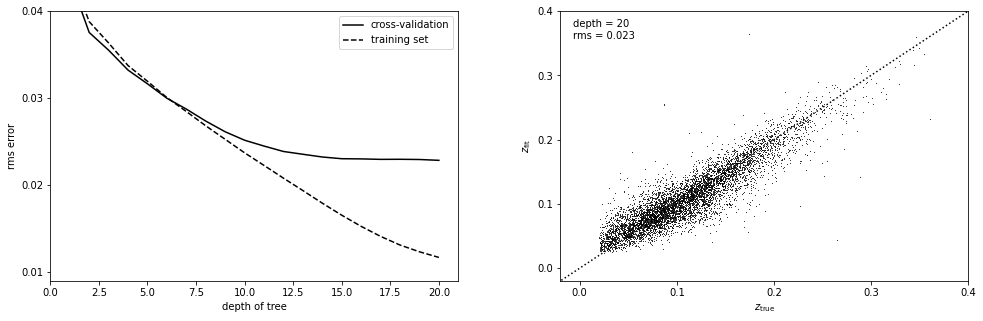

In [24]:
# Plot the results
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

## Our Experiment 

1) We are now going to explore how changing the amount of data in the test and training samples effects the 
results of the random forest.  

2) we will experiment with over fitting and under fitting 

3) we will experiment with using less information (e.g. not as many filters!) 